In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torcheval.metrics

from sklearn.datasets import make_moons

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')
from tools import *

assert(torch.cuda.is_available())
device = torch.device("cuda")

c:\Users\Miguel\miniconda3\envs\ml3\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


<Axes: >

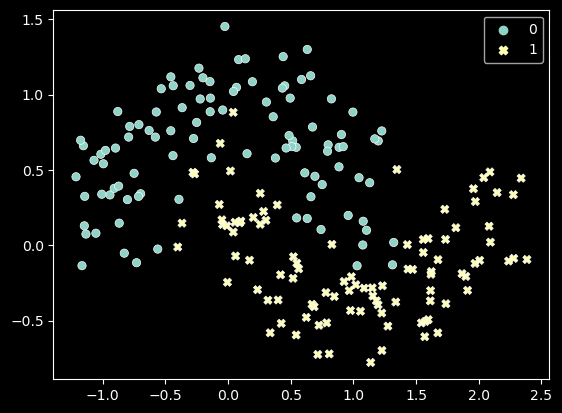

In [2]:
X_train, y_train = make_moons(n_samples=8000, noise=0.2)
X_test, y_test = make_moons(n_samples=200, noise=0.2)
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_test, style=y_test)


In [3]:
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)
training_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
testing_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True)

model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
).to(device)

optimizer = torch.optim.AdamW(model.parameters())
f_loss = nn.CrossEntropyLoss()

In [4]:
y0_hat = model(train_dataset[:50][0].to(device))
y0 = train_dataset[:50][1].to(device)
print(y0_hat.shape)
print(y0.shape)

torch.Size([50, 2])
torch.Size([50])


In [5]:
#our classifier returns a [batch_len, n_classes] tensor of logits. but the
#torcheval metrics expect a [batch_len,] tensor of integer class labels, so we
#need to apply argmax along each row of the classifier output to get the
#predicted class
print(torcheval.metrics.functional.binary_accuracy( torch.argmax(y0_hat, axis=1) , y0))
print(torcheval.metrics.functional.binary_f1_score( torch.argmax(y0_hat, axis=1) , y0))

tensor(0.1200, device='cuda:0')
tensor(0.0435, device='cuda:0')


In [6]:
#to apply this preprocessing automatically to any metric functional, we pass the
#functional to the from_logits wrapper and use the wrapped functional
binary_accuracy_from_logits = from_logits(torcheval.metrics.functional.binary_accuracy)
binary_f1_from_logits = from_logits(torcheval.metrics.functional.binary_f1_score)
print(binary_accuracy_from_logits(y0_hat, y0))
print(binary_f1_from_logits(y0_hat, y0))

metrics = {"Accuracy": binary_accuracy_from_logits, "F1 Score": binary_f1_from_logits}

tensor(0.1200, device='cuda:0')
tensor(0.0435, device='cuda:0')


In [7]:
results = run_epoch( model, f_loss, optimizer, training_loader, metrics=metrics, desc=None, show_progress=True)
results